In [1]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LinearRegression
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-09


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,229986631680,0.995519,36804000000,Technology,2.882,56.189999,44.986347,52.599998,52.340000,53.160000,52.430000,24128600.0
SITC,2533060352,0.844472,1499137000,Real Estate,1.043,13.490000,NaN,13.840000,13.780000,14.030000,14.030000,1920086.0
UAL,22748133376,1.223721,10320000000,Industrials,9.838,90.669998,85.220001,85.459999,86.480003,87.629997,86.980003,2380100.0
TROW,26297821184,1.069091,6579100000,Financial Services,7.945,108.959999,112.439903,107.260002,107.040001,110.250000,108.650002,1338400.0
ISRG,61556834304,1.269715,7265300000,Healthcare,10.129,533.159973,525.359985,503.769989,505.359985,519.409973,515.500000,491700.0


In [4]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [5]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2008-01-02,320.000000,296.904999,312.381012,320.000000,379785.0,320.000000,SITC
1,2008-01-03,334.286011,323.809998,323.809998,334.286011,144585.0,334.286011,SITC
2,2008-01-04,331.333008,322.856995,326.761993,323.761993,13020.0,323.761993,SITC
3,2008-01-07,319.286011,312.381012,312.381012,319.286011,2940.0,319.286011,SITC
4,2008-01-08,318.951996,306.761993,312.856995,318.951996,25725.0,318.951996,SITC


In [6]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')

    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=3)
    
    prices_temp.index = pd.to_datetime(prices_temp.index)
    
    p = prices_temp.loc[start_date:end_date]
    
    return p.dropna(axis=1)
p = transform_prices(prices, '2019-08-07')
returns = p.pct_change().drop(p.index[0])
print(p.shape)
returns.head()

(755, 894)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-09,0.004658,-0.009569,0.006987,-0.014093,0.004060,0.006331,-0.000564,0.025528,0.001333,0.008754,...,0.001964,-0.000561,-0.035752,0.000704,0.010861,0.083290,-0.026925,0.002088,-0.024823,0.002559
2016-08-10,0.001265,-0.001932,-0.011853,0.000901,-0.007444,-0.004943,-0.008125,0.001054,-0.005989,-0.003207,...,-0.005270,-0.006514,-0.022690,0.004923,-0.031332,0.031837,-0.022690,-0.017014,-0.010909,0.017279
2016-08-11,0.013050,0.008712,0.022821,0.000360,-0.000648,0.007828,0.011945,0.005103,0.005356,-0.022129,...,-0.006395,0.017183,-0.000566,-0.002099,0.004499,0.001697,-0.002548,-0.001060,-0.022059,0.005018
2016-08-12,0.000208,-0.023992,-0.001144,-0.004259,0.002316,0.003585,-0.000450,-0.003223,-0.000222,0.008388,...,-0.001197,-0.000222,-0.002833,-0.001052,-0.001236,0.027568,-0.006245,-0.004951,-0.003759,-0.001728
2016-08-15,0.006232,0.034415,0.027205,0.010602,0.012017,0.002976,0.005399,-0.002425,0.002442,-0.005610,...,-0.001049,-0.000222,0.010511,0.008775,0.004407,0.029826,0.011711,0.017413,0.022641,0.007695


In [7]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
y = p.loc['2016-08-08':'2017-08-07', 'AAPL'].values
print(y.shape)
t1 = np.arange(252)
t2 = np.arange(252)**2
X = np.array([t1, t2]).T
lr = LinearRegression()
lr.fit(X,y)
print(lr.coef_[0], lr.coef_[1])

(252,)
0.19584919227249611 8.924274343539297e-05


In [12]:
def rolling_beta(y):
    t1 = np.arange(252)
    t2 = np.arange(252)**2
    X = np.array([t1, t2]).T
    if np.all(np.isfinite(y)):
        lr = LinearRegression()
        lr.fit(X, y)
        return lr.coef_[0]
    else:
        return np.nan


rolling_beta = p.rolling(252).apply(rolling_beta).dropna()
rolling_beta.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  del sys.path[0]


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-07,-0.019243,0.136173,0.094423,0.408315,0.195849,-0.078751,-0.043998,-0.272328,-0.052856,-0.017621,...,1.348103,-0.051124,-0.049220,0.056742,-0.291652,0.204837,-0.048797,0.175248,-0.006850,-0.023399
2017-08-08,-0.016485,0.135670,0.093126,0.413942,0.198358,-0.076368,-0.035257,-0.273169,-0.050303,-0.016468,...,1.361374,-0.049946,-0.047155,0.055309,-0.281394,0.201801,-0.046706,0.173977,-0.006773,-0.021145
2017-08-09,-0.013393,0.135407,0.092120,0.418149,0.200815,-0.073879,-0.026380,-0.271973,-0.047605,-0.015003,...,1.374799,-0.049053,-0.044148,0.053479,-0.269425,0.202463,-0.043480,0.172868,-0.006748,-0.019112
2017-08-10,-0.009825,0.135437,0.091092,0.423398,0.204744,-0.070928,-0.017595,-0.268226,-0.044725,-0.013556,...,1.387970,-0.048434,-0.040428,0.051773,-0.258707,0.204687,-0.039522,0.171732,-0.006682,-0.016182
2017-08-11,-0.006161,0.135587,0.090491,0.428037,0.207859,-0.067708,-0.008698,-0.264374,-0.041827,-0.012572,...,1.398587,-0.047242,-0.036901,0.050146,-0.248210,0.206535,-0.035794,0.170618,-0.006652,-0.013092


In [13]:
def rolling_gamma(y):
    t1 = np.arange(252)
    t2 = np.arange(252)**2
    X = np.array([t1, t2]).T
    if np.all(np.isfinite(y)):
        lr = LinearRegression()
        lr.fit(X, y)
        return lr.coef_[1]
    else:
        return np.nan


rolling_gamma = p.rolling(252).apply(rolling_gamma).dropna()
rolling_gamma.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  del sys.path[0]


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-07,0.000361,-0.000339,-0.000160,-0.002313,0.000089,0.000478,0.000374,0.001528,0.000349,0.000051,...,-0.003924,0.000403,0.000399,-0.000190,0.001219,-0.000130,0.000402,-0.000464,0.000042,0.000315
2017-08-08,0.000352,-0.000336,-0.000156,-0.002342,0.000083,0.000472,0.000338,0.001542,0.000341,0.000047,...,-0.003988,0.000400,0.000394,-0.000185,0.001182,-0.000120,0.000397,-0.000461,0.000042,0.000307
2017-08-09,0.000341,-0.000334,-0.000154,-0.002366,0.000077,0.000465,0.000301,0.001548,0.000333,0.000042,...,-0.004053,0.000399,0.000384,-0.000178,0.001137,-0.000124,0.000385,-0.000458,0.000042,0.000299
2017-08-10,0.000328,-0.000334,-0.000152,-0.002395,0.000062,0.000456,0.000264,0.001542,0.000324,0.000037,...,-0.004119,0.000398,0.000369,-0.000172,0.001094,-0.000134,0.000369,-0.000456,0.000042,0.000288
2017-08-11,0.000315,-0.000335,-0.000152,-0.002421,0.000052,0.000446,0.000228,0.001537,0.000315,0.000034,...,-0.004176,0.000396,0.000355,-0.000166,0.001054,-0.000143,0.000355,-0.000454,0.000042,0.000277


In [17]:
def create_conditional_factor_sector_neutral(beta, gamma, data):

    # create factor
    beta_ranked = beta.rank(axis=1, method='first')
    gamma_ranked = gamma.rank(axis=1, method='first')
    fr = beta_ranked * gamma_ranked
    
    sector_data = data['sector']
    index_ = sector_data.index.intersection(fr.columns)
    sector_data = sector_data.loc[index_]
    df = fr.loc[:, index_].dropna().copy() # to use only the stocks that are in sector_data
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

def create_conditional_factor(beta, gamma, data):

    # create factor
    beta_ranked = beta.rank(axis=1, method='first')
    gamma_ranked = gamma.rank(axis=1, method='first')
    return beta_ranked * gamma_ranked
    

In [21]:
sector_neutral_factor = create_conditional_factor_sector_neutral(rolling_beta, rolling_gamma, data)
print(sector_neutral_factor.shape)
factor = create_conditional_factor(rolling_beta.loc[:,sector_neutral_factor.columns], 
                                   rolling_gamma.loc[:, sector_neutral_factor.columns], data)
factor.shape

(504, 877)


(504, 877)

In [23]:
cf = factor.stack()
cfsn = sector_neutral_factor.stack()
print(cf.shape)
print(cfsn.shape)
adj_p = p.loc[factor.index,:].copy()
print(adj_p.shape)

(442008,)
(442008,)
(504, 894)


In [52]:
sector_data_dict = data.loc[factor.columns,'sector'].to_dict()

In [53]:
factor_data = {}
factor_data['cond_factor'] = al.utils.get_clean_factor_and_forward_returns(cf, adj_p, periods=[1], 
                                                                           groupby=sector_data_dict)
factor_data['cond_factor_sector_neutral'] = al.utils.get_clean_factor_and_forward_returns(cfsn, adj_p, periods=[1],
                                                                                         groupby=sector_data_dict)

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [54]:
factor_data['cond_factor'].head()

1D    factor               group  factor_quantile
date       asset                                                         
2017-08-07 CSCO  -0.005339  158911.0          Technology                4
           UAL   -0.008773   34440.0         Industrials                1
           TROW  -0.002159  192546.0  Financial Services                5
           ISRG  -0.002402    7830.0          Healthcare                1
           NVR    0.014042     877.0   Consumer Cyclical                1

In [55]:
factor_return_list = []
for key, val in factor_data.items():
    factor_return = al.performance.factor_returns(val)
    factor_return.columns = [key]
    factor_return_list.append(factor_return)

In [56]:
factor_return_list[0].head()

,cond_factor
date,
2017-08-07,-0.000828
2017-08-08,-0.000139
2017-08-09,-0.000240
2017-08-10,0.000338
2017-08-11,0.002791


In [57]:
factor_return_list[1].head()

,cond_factor_sector_neutral
date,
2017-08-07,-0.000905
2017-08-08,0.000250
2017-08-09,0.001550
2017-08-10,-0.000656
2017-08-11,0.000618


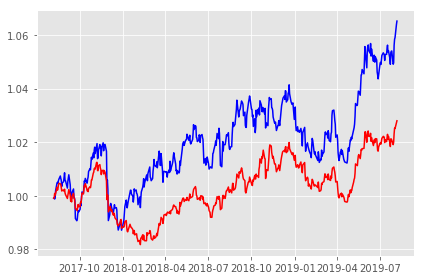

In [58]:
fac_1 = factor_return_list[0]
fac_2 = factor_return_list[1]
ret1 = (fac_1 + 1.0).cumprod() 
ret2 = (fac_2 + 1.0).cumprod() 

plt.plot(ret1, c='b')
plt.plot(ret2, c='r')
plt.legend()

plt.tight_layout()

In [59]:
fra_list = []
for key, val in factor_data.items():
    fra = al.performance.factor_rank_autocorrelation(val).to_frame()
    fra.columns = [key]
    fra_list.append(fra)
    
fra_df = pd.concat(fra_list, axis=1)

In [60]:
fra_df.head()

,cond_factor,cond_factor_sector_neutral
date,,
2017-08-07,NaN,NaN
2017-08-08,0.998206,0.998268
2017-08-09,0.997840,0.997799
2017-08-10,0.996690,0.996230
2017-08-11,0.998267,0.998054


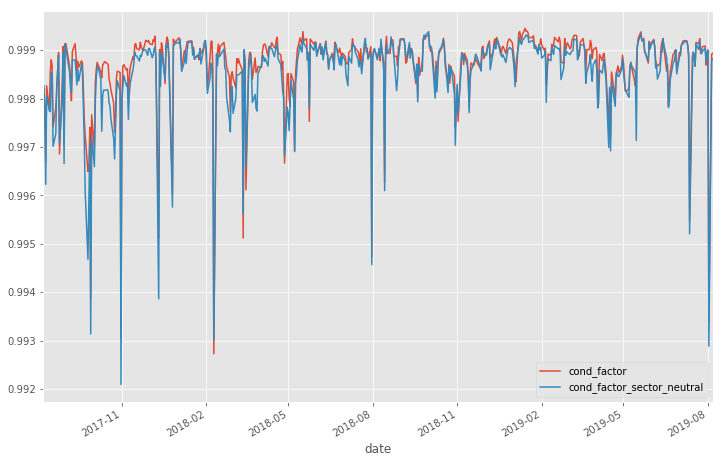

In [61]:
fra_df.plot(figsize=(12,8))

# Quantile Analysis

In [62]:
factor_names = factor_data.keys()
factor_names

dict_keys(['cond_factor', 'cond_factor_sector_neutral'])

In [63]:
ls_qr = []
for i, factor_name in enumerate(factor_names):
    quantile_return, quantile_stderr = al.performance.mean_return_by_quantile(factor_data[factor_name])
    quantile_return.columns = [factor_name]
    ls_qr.append(quantile_return)
df_ls_qr = pd.concat(ls_qr, axis=1)
df_ls_qr

,cond_factor,cond_factor_sector_neutral
factor_quantile,,
1,0.000052,0.000084
2,-0.000100,-0.000123
3,-0.000135,-0.000071
4,-0.000042,-0.000123
5,0.000225,0.000232


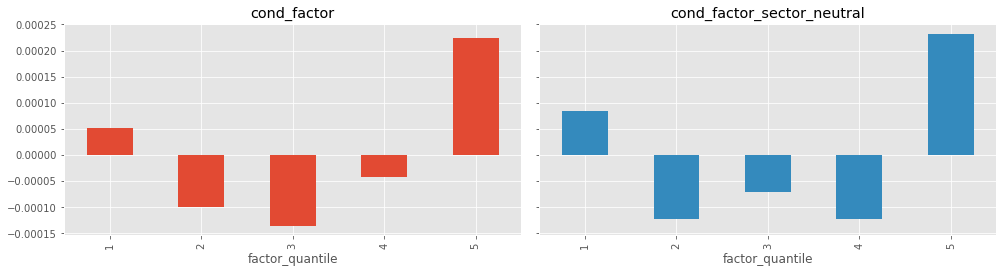

In [64]:
df_ls_qr.plot.bar(subplots=True, sharey=True, layout=(4,2), figsize=(14, 14), legend=False)
plt.tight_layout()

## Convert to basis points

In [65]:
df_ls_qr_bp = 1e4 * df_ls_qr
df_ls_qr_bp

,cond_factor,cond_factor_sector_neutral
factor_quantile,,
1,0.520915,0.839462
2,-1.000594,-1.231399
3,-1.353010,-0.706760
4,-0.418078,-1.230106
5,2.247217,2.324006


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x139bede10>,
      dtype=object)

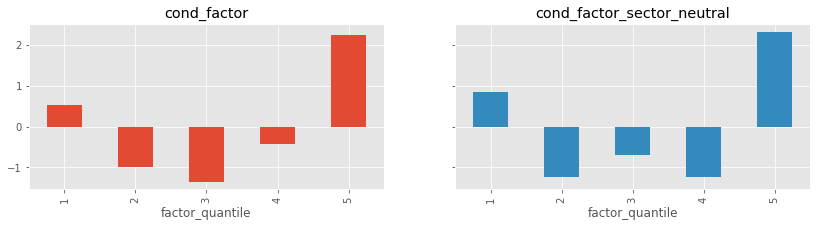

In [66]:
df_ls_qr_bp.plot.bar(subplots=True, sharey=True, layout=(4,2), figsize=(14,14), legend=False)

In [67]:
sfpr = al.performance.factor_returns(factor_data['cond_factor'])
mean = sfpr.mean()
std = sfpr.std()
sharpe = np.sqrt(252) * mean/std
sharpe

1D    0.827815
dtype: float64

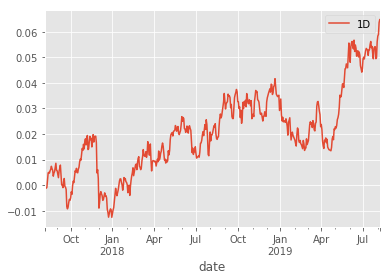

In [68]:
sfpr.cumsum().plot()

In [69]:
autocorr = al.performance.factor_information_coefficient(factor_data['cond_factor'])
autocorr.head()

,1D
date,
2017-08-07,0.028322
2017-08-08,0.039561
2017-08-09,0.090470
2017-08-10,0.021017
2017-08-11,0.073897


In [70]:
autocorr.mean()

1D    0.008562
dtype: float64

In [71]:
sfpr = al.performance.factor_returns(factor_data['cond_factor_sector_neutral'])
mean = sfpr.mean()
std = sfpr.std()
sharpe = np.sqrt(252) * mean/std
sharpe

1D    0.606233
dtype: float64

In [72]:
autocorr = al.performance.factor_information_coefficient(factor_data['cond_factor_sector_neutral'])
autocorr.head()

,1D
date,
2017-08-07,0.018398
2017-08-08,0.039933
2017-08-09,0.128184
2017-08-10,-0.054707
2017-08-11,0.003405


In [73]:
autocorr.mean()

1D    0.007107
dtype: float64